In [1]:
# all internal libraries
import pathlib
import time
import datetime
import io
import urllib
import tempfile
import functools
import logging

# dependencies
import requests
import shapely.geometry
import shapely.wkt
import networkx as nx
import simpy
import numpy as np
import pandas as pd
import pyproj

# our software
import opentnsim.core

%matplotlib inline

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()


In [2]:
# link to the latets version of the network
url = 'https://zenodo.org/record/3981105/files/network_digital_twin_v0.1.yaml'

# define the coorinate system
geod = pyproj.Geod(ellps="WGS84")


# Load the network
The Topological Network of the Dutch Fairway Informtion system is freely [available](http://dx.doi.org/10.5281/zenodo.3981105). The network is created from the data from the [vaarweginformatie](https://vaarweginformatie.nl) dataset from Rijkswaterstaat. The data is transformed into a topological network, a graph, that can be used for route planning, and economic and logistic modelling. Here we will load the data from the internet. 

In [3]:

# The network version 0.1 contains the lat/lon distance in a length property. 
# But we need the "great circle" or projected distance. 
# Let's define a function to recompute it.
def edge_length(edge):
    """compute the great circle length of an edge"""
    # get the geometry
    geom = edge['geometry']
    # get lon, lat
    lats, lons = np.array(geom).T
    distance = geod.line_length(lons, lats)
    return distance
 
# now create the function can load the network

# store the result so it will immediately give a result
@functools.lru_cache
def load_fis_network(url):
    """load the topological fairway information system network"""

    # get the data from the url
    resp = requests.get(url)
    # convert to file object
    stream = io.StringIO(resp.text)
    
    # This will take a minute or two
    # Here we convert the network to a networkx object
    G = nx.read_yaml(stream)

    # some brief info
    n_bytes = len(resp.content)
    msg = '''Loaded network from {url} file size {mb:.2f}MB. Network has {n_nodes} nodes and {n_edges} edges.'''
    summary = msg.format(url=url, mb=n_bytes / 1000**2, n_edges=len(G.edges), n_nodes=len(G.nodes))
    logger.info(summary)

    # The topological network contains information about the original geometry. 
    # Let's convert those into python shapely objects for easier use later
    for n in G.nodes:
        G.nodes[n]['geometry'] = shapely.geometry.Point(G.nodes[n]['X'], G.nodes[n]['Y'])
    for e in G.edges:
        edge = G.edges[e]
        edge['geometry'] = shapely.wkt.loads(edge['Wkt'])
        edge['length'] = edge_length(edge)    
    
    return G

In [4]:
G = load_fis_network(url)

INFO:root:Loaded network from https://zenodo.org/record/3981105/files/network_digital_twin_v0.1.yaml file size 17.05MB. Network has 13876 nodes and 14361 edges.


# Inspect the network

The network is now stored in a undirected [networkx](https://networkx.github.io/documentation/stable/tutorial.html) [Graph](https://networkx.github.io/documentation/stable/reference/classes/graph.html) object. You can use it to extract edges, nodes and their properties. 

In [5]:
# Show the properties of the edges in a table
edge_df = pd.DataFrame(
    G.edges[edge] for edge in G.edges
)
edge_df.head()


,Classification,Code,CoupledDepth,CoupledLength,CoupledWidth,Description,EndJunctionId,GeneralDepth,GeneralHeight,GeneralLength,...,SeaFairingHeight,SeaFairingLength,SeaFairingWidth,StartJunctionId,WidePushedDepth,WidePushedLength,WidePushedWidth,Wkt,length,geometry
0,CEMT,IV,NaN,NaN,NaN,"Rijn - Hernekanaalschip, Eenbaksduwstel",8.86452e+06,NaN,NaN,NaN,...,NaN,NaN,NaN,8.86436e+06,NaN,NaN,NaN,"LINESTRING (4.69594354276411 51.7206871440897,...",186.483382,"LINESTRING (4.69594354276411 51.7206871440897,..."
1,CEMT,IV,NaN,NaN,NaN,"Rijn - Hernekanaalschip, Eenbaksduwstel",8.86611e+06,NaN,NaN,90.0,...,NaN,NaN,NaN,8.86452e+06,NaN,NaN,NaN,"LINESTRING (4.69599104281199 51.7190069976013,...",114.468704,"LINESTRING (4.69599104281199 51.7190069976013,..."
2,CEMT,I,NaN,NaN,NaN,Spits,B42301_A,NaN,NaN,90.0,...,NaN,NaN,NaN,8.86611e+06,NaN,NaN,NaN,"LINESTRING (4.69542511729365 51.7181587042569,...",316.428991,"LINESTRING (4.69542511729365 51.7181587042569,..."
3,CEMT,_0,NaN,NaN,NaN,Kleine vaartuigen en recreatievaart,8.86149e+06,NaN,NaN,20.0,...,NaN,NaN,NaN,8.86598e+06,NaN,NaN,NaN,"LINESTRING (4.82202214280621 52.1510773598852,...",1094.285531,"LINESTRING (4.82202214280621 52.1510773598852,..."
4,CEMT,_0,NaN,NaN,NaN,Kleine vaartuigen en recreatievaart,8.86598e+06,NaN,NaN,20.0,...,NaN,NaN,NaN,8.86751e+06,NaN,NaN,NaN,"LINESTRING (4.81473279746155 52.1566328298255,...",1034.989616,"LINESTRING (4.81473279746155 52.1566328298255,..."


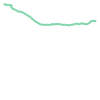

In [6]:
# get an edge from the network. You can use the start/endJunction Id to get an edge..
# We refer to the node pair with the variable e
e = ('FN0', 'FN547')
# Get the edge
edge = G.edges[e]
# Show it's original geometry
edge['geometry']

In [7]:
# we're sailing from A to B
a = G.nodes[e[0]]
b = G.nodes[e[1]]
a

{'X': 16.98656174475468,
 'Y': 48.16587902631468,
 'geometry': <shapely.geometry.point.Point at 0x15583ae80>}

# Load the network into OpenTNSim

In [8]:
# To run OpenTNSim we define a simpy as a simulation environment
# By default it will start in 1970-01-01 
env = simpy.Environment()
# Add graph to environment. The convention is to store it as property FG (fairway graph)
env.FG = G

In [9]:
# Make a general vessel class out of mix-ins
TransportResource = type('TransportResource', 
                         (opentnsim.core.Identifiable, opentnsim.core.ContainerDependentMovable, 
                          opentnsim.core.HasResource, opentnsim.core.Routeable), {})



# We have to pass a velocity  function
def compute_v_provider(v_empty, v_full):
    return lambda x: 1

data_vessel = {"env": None,
               "name": "Vessel number 1",
               "route": None,
               "geometry": a['geometry'],  # lon, lat
               "capacity": 1_000,
               "compute_v": compute_v_provider(v_empty=1, v_full=1)}

# create the transport processing resource
vessel = TransportResource(**data_vessel)


In [10]:
# Now define the sites (A and B)
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Log, opentnsim.core.Locatable, opentnsim.core.HasResource), {})

data_node_1 = {"env": [],
               "name": "Node 1",
               "geometry": shapely.geometry.Point(a['X'], a['Y'])}
data_node_2 = {"env": [],
               "name": "Node 2",
               "geometry": shapely.geometry.Point(b['X'], b['Y'])}

node_1 = Node(**data_node_1)
node_2 = Node(**data_node_2)

nodes = [node_1, node_2]

In [11]:
# define the route along which we're going to sail
path = [e]

In [12]:
# Add environment and path to the vessel
vessel.env = env
vessel.route = path[0]
vessel.route

('FN0', 'FN547')

In [13]:
# Now we can run a first simulation
def start(env, vessel):
    yield from vessel.move()
        
env.process(start(env, vessel))
env.run()


In [14]:
# The vessel should now have sailed from A to B 
pd.DataFrame(vessel.log)

,Message,Timestamp,Value,Geometry
0,Sailing from node FN0 to node FN547 start,1970-01-01 01:00:00.000000,0,POINT (16.98656174475468 48.16587902631468)
1,Sailing from node FN0 to node FN547 start,1970-01-02 17:06:43.939033,0,POINT (18.849226684024 47.814679272474)


In [15]:
# let's lookup how long it took
t = vessel.log['Timestamp'][1] - vessel.log['Timestamp'][0] 
m_per_s = edge['length'] / t.total_seconds()
# The ship is actualy sailing a bit to fast because in the default move function it is going straight from A to B
m_per_s 

1.5841638781327159